# ML Project: Dog breed classifiaction

## Import libraries

In [ ]:
# Imports
import os
import sys
import numpy as np
import pandas as pd
import cv2
import time
import json
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# Import pretrained models
from tensorflow.keras.applications import ResNet50V2,VGG16, InceptionV3, MobileNetV2, DenseNet121

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

In [ ]:
# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)

tensorflow version 2.3.0
keras version 2.4.0


## stanford Dog DataSet

In [ ]:
!rm -rf DatasetStore

In [ ]:
import requests
import tarfile
dataset_path = "DatasetStore"

# Download and extract dataset
if not os.path.exists(dataset_path):
  os.mkdir(dataset_path)
  packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
  packet_file = os.path.basename(packet_url)
  packet_file = os.path.join(dataset_path, packet_file)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(packet_file, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)

  packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
  packet_file = os.path.basename(packet_url)
  packet_file = os.path.join(dataset_path, packet_file)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(packet_file, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)

Display some training images

---



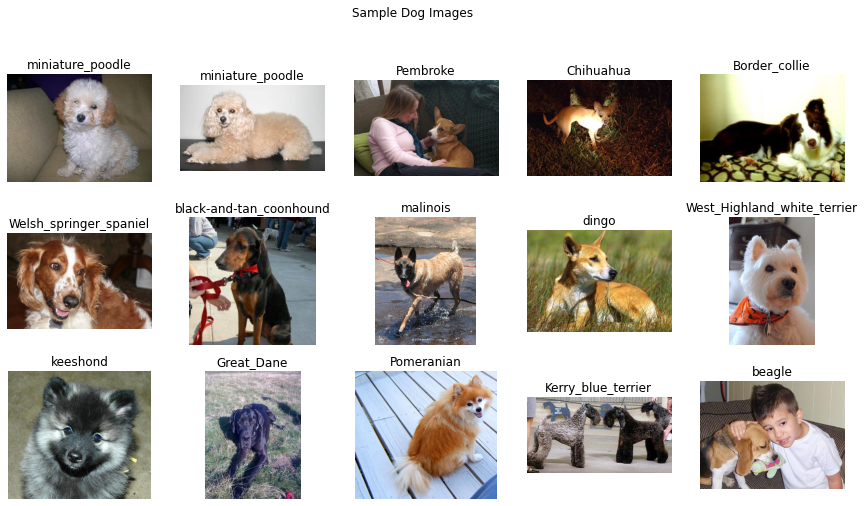

In [ ]:


breed_list = os.listdir('DatasetStore/Annotation/') # list of all breeds for further demo

# Train images
fig = plt.figure(figsize=(15,8))
for i in range(15):
    axs = fig.add_subplot(3,5,i+1)
    breed = np.random.choice(breed_list) # random breed
    dog = np.random.choice(os.listdir('DatasetStore/Annotation/' + breed)) # random image
    img = Image.open('DatasetStore/Images/' + breed + '/' + dog + '.jpg')
    tree = ET.parse('DatasetStore/Annotation/' + breed + '/' + dog) # init parser for file given
    root = tree.getroot()
    object_1 = root.findall('object')[0]; # finding all dogs. An array
    name = object_1.find('name').text;
    axs.set_title(name)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("Sample Dog Images")
plt.show()

In [ ]:
breed_list = os.listdir('DatasetStore/Annotation/'); # list of all breeds for further demo
breed_list.sort()
for i,breed in enumerate(breed_list):
  breed_list[i] = breed[10:];

# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(breed_list))
index2label = dict((index, name) for index, name in enumerate(breed_list))
print(breed_list[:3])

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']


Load data

In [ ]:
breed_list = os.listdir('DatasetStore/Annotation/') # list of all breeds for further demo
breed_list.sort()
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(breed_list))
index2label = dict((index, name) for index, name in enumerate(breed_list))

images = []
annotations =[]
for breed in breed_list:
  image_files = os.listdir('DatasetStore/Images/' + breed)
  image_files.sort()
  images.extend([os.path.join('DatasetStore/Images/',breed,f) for f in image_files])
  annotations.extend([os.path.join('DatasetStore/Annotation/',breed,f.replace(".jpg","")) for f in image_files])

for idx, ann in enumerate(annotations):
    annotations[idx] = ann.split("/")[2] # add dog breed name

# Prepare train test validate datasets
Xs = np.asarray(images)
Ys = np.asarray(annotations)

print('Xs shape',Xs.shape)
print(Xs[:5])
print('Ys shape',Ys.shape)
print(Ys[:5])

# Split into train_validate + test data
train_validate_x,test_x, train_validate_y, test_y = train_test_split(Xs,Ys,test_size=0.1)

print("train_validate_x shape:",train_validate_x.shape)
print('train_validate_x[:5]:',train_validate_x[:5])
print("train_validate_y shape:",train_validate_y.shape)
print('train_validate_y[:5]:',train_validate_y[:5])

print("test_x shape:",test_x.shape)
print('test_x[:5]:',test_x[:5])
print("test_y shape:",test_y.shape)
print('test_y[:5]:',test_y[:5])

Xs shape (20580,)
['DatasetStore/Images/n02085620-Chihuahua/n02085620_10074.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_10131.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_10621.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_1073.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_10976.jpg']
Ys shape (20580,)
['n02085620-Chihuahua' 'n02085620-Chihuahua' 'n02085620-Chihuahua'
 'n02085620-Chihuahua' 'n02085620-Chihuahua']
train_validate_x shape: (18522,)
train_validate_x[:5]: ['DatasetStore/Images/n02100735-English_setter/n02100735_523.jpg'
 'DatasetStore/Images/n02089078-black-and-tan_coonhound/n02089078_188.jpg'
 'DatasetStore/Images/n02113978-Mexican_hairless/n02113978_341.jpg'
 'DatasetStore/Images/n02095570-Lakeland_terrier/n02095570_3213.jpg'
 'DatasetStore/Images/n02106030-collie/n02106030_15172.jpg']
train_validate_y shape: (18522,)
train_validate_y[:5]: ['n02100735-English_setter' 'n02089078-black-and-tan_coonhound'
 'n02113978-Mexican_hai

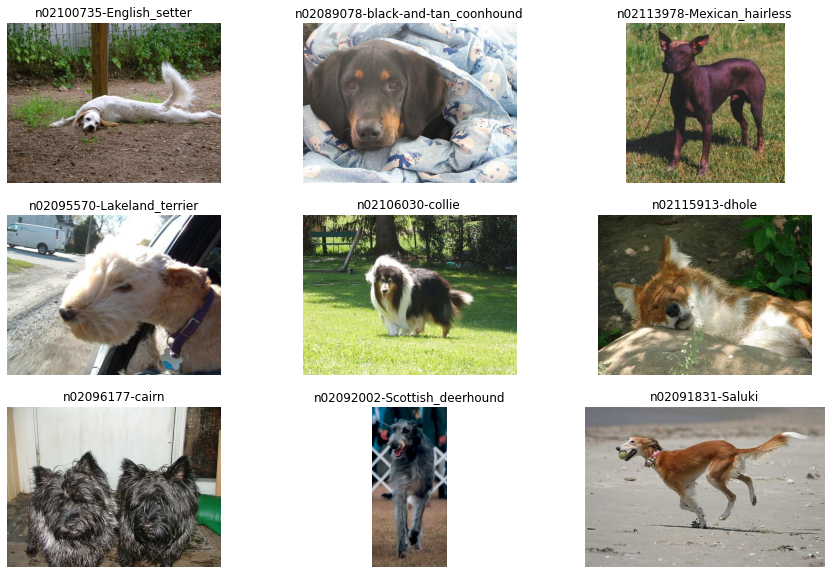

In [ ]:
# View a few train images
fig = plt.figure(figsize=(15,10))

for idx in range(9):
  sample_input = cv2.imread(train_validate_x[idx])
  sample_input = cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB)
  breed = train_validate_y[idx];
  axs = fig.add_subplot(3,3,idx+1)
  axs.set_title(breed)
  plt.imshow(sample_input)
  plt.axis('off')

plt.show();



## Building Data Generator

In [ ]:
validation_percent = 0.2
image_width = 128
image_height = 128
num_channels = 3
num_classes = len(breed_list);

epochs = 30
train_batch_size = 32
validation_batch_size = 32
test_batch_size = 32
train_shuffle_size = train_batch_size * 3
validation_shuffle_size = validation_batch_size * 3

# Split data into train / validation
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=validation_percent)

#  Converts to binary class matrix (One-hot-encoded)
train_processed_y = np.asarray([label2index[label] for label in train_y])
validate_processed_y = np.asarray([label2index[label] for label in validate_y])
test_processed_y = np.asarray([label2index[label] for label in test_y])
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

train_data_count = train_x.shape[0]
steps_per_epoch = np.int(train_data_count / train_batch_size)
validation_data_count = validate_x.shape[0]
validation_steps = np.int(validation_data_count / validation_batch_size)

# Prepare the data
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image,[image_height,image_width])
    return image, label

# Normalize pixels
def normalize(image, label):
    image = image/255
    return image, label

def build_data_generators(train_data_process_list=[load_image,normalize],validate_data_process_list=[load_image,normalize],test_data_process_list=[load_image,normalize]):

    # Create TF Dataset
    train_data = tf.data.Dataset.from_tensor_slices((train_x.tolist(), train_processed_y.tolist()))
    validation_data = tf.data.Dataset.from_tensor_slices((validate_x.tolist(), validate_processed_y.tolist()))
    test_data = tf.data.Dataset.from_tensor_slices((test_x.tolist(), test_processed_y.tolist()))


    # Train data
    # Shuffle
    train_data = train_data.shuffle(train_data_count)
    # Apply all data processing logic
    for process in train_data_process_list:
        train_data = train_data.map(process, num_parallel_calls=AUTOTUNE)

    train_data = train_data.repeat(epochs).batch(train_batch_size)

    # Validation data
    # Shuffle
    validation_data = validation_data.shuffle(validation_data_count)
    # Apply all data processing logic
    for process in validate_data_process_list:
        validation_data = validation_data.map(process, num_parallel_calls=AUTOTUNE)

    validation_data = validation_data.repeat(epochs).batch(validation_batch_size)

    # Test data
    # Apply all data processing logic
    for process in test_data_process_list:
        test_data = test_data.map(process, num_parallel_calls=AUTOTUNE)
    test_data = test_data.repeat(1).batch(test_batch_size)

    return train_data, validation_data, test_data

train_data, validation_data, test_data = build_data_generators()
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <BatchDataset shapes: ((None, 128, 128, 3), (None, 120)), types: (tf.float32, tf.float32)>
validation_data <BatchDataset shapes: ((None, 128, 128, 3), (None, 120)), types: (tf.float32, tf.float32)>
test_data <BatchDataset shapes: ((None, 128, 128, 3), (None, 120)), types: (tf.float32, tf.float32)>


In [ ]:


class JsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, decimal.Decimal):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(JsonEncoder, self).default(obj)

def get_model_metrics():
    with open("./SavedModels/model_metrics.json") as json_file:
        model_metrics = json.load(json_file)

    return model_metrics

def save_model_metrics(model_name="model_1",metrics={}):
    if os.path.exists("./SavedModels/model_metrics.json"):
        with open("./SavedModels/model_metrics.json") as json_file:
            model_metrics = json.load(json_file)
    else:
        model_metrics = {}

    model_metrics[model_name] = metrics

    # Save the json
    with open("./SavedModels/model_metrics.json", 'w') as json_file:
        json_file.write(json.dumps(model_metrics, cls=JsonEncoder))

def save_model(path="./SavedModels",model_name="model01"):
    filename = "./SavedModels/"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    # Save the enitire model (structure + weights)
    model.save(os.path.join(path,model_name+".hdf5"))

    # Save only the weights
    model.save_weights(os.path.join(path,model_name+".h5"))

    # Save the structure only
    model_json = model.to_json()
    with open(os.path.join(path,model_name+".json"), "w") as json_file:
        json_file.write(model_json)

def get_model_size(path="./SavedModels",model_name="model01"):
    model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
    return model_size

def evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer,momentum = None, save=True):

    # Get the model train history
    model_train_history = training_results.history
    # Get the number of epochs the training was run for
    num_epochs = len(model_train_history["loss"])

    # Plot training results
    fig = plt.figure(figsize=(15,5))
    axs = fig.add_subplot(1,2,1)
    axs.set_title('Loss')
    # Plot all metrics
    for metric in ["loss","val_loss"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    axs = fig.add_subplot(1,2,2)
    axs.set_title('Accuracy')
    # Plot all metrics
    for metric in ["accuracy","val_accuracy"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    plt.show()

    # Evaluate on test data
    evaluation_results = model.evaluate(test_data)
    print('Evaluation results: [loss, accuracy]', evaluation_results)

    if save:
        # Save model
        save_model(model_name=model.name)
        model_size = get_model_size(model_name=model.name)

        # Save model history
        with open(os.path.join("./SavedModels",model.name+"_train_history.json"), "w") as json_file:
            json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

        trainable_parameters = model.count_params()

        # Save model metrics
        metrics ={
            "trainable_parameters":trainable_parameters,
            "execution_time":execution_time,
            "loss":evaluation_results[0],
            "accuracy":evaluation_results[1],
            "model_size":model_size,
            "learning_rate":learning_rate,
            "batch_size":batch_size,
            'momentum': momentum,
            "epochs":epochs,
            "optimizer":type(optimizer).__name__
        }
        save_model_metrics(model_name=model.name,metrics=metrics)

Compare all models

In [ ]:
resnet50_v2 = ResNet50V2(
    include_top=False,
    input_shape=(128, 128, 3)
)

94674944/94668760 [==============================] - 1s 0us/step


### Build model

In [ ]:
# Build model for Resnet
def build_resnet_model(model_name = 'ResNet50V2',print_summary=True):
  # Set all layers as hidden
  for layer in resnet50_v2.layers:
      layer.trainable = False

  # Input
  model_input = resnet50_v2.layers[0].input

  # Extract final pool layer
  hidden = resnet50_v2.layers[-1]

  # Flatten
  hidden = layers.Flatten()(hidden.output)

  # Output Layer
  output = layers.Dense(units=120, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name=model_name)

  # Print the model architecture
  if print_summary:
    print(model.summary())

  return model

### Training params

In [ ]:

# Training Params

batch_size = 32
epochs = 50


# Early Stopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10);

# Model Checkpoint
checkpoint_filepath = './Checkpoints/checkpoint_ResNet50V2'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

# Build the model
model = build_resnet_model()

# Optimier
optimizer = optimizers.Adam()

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])




Model: "ResNet50V2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

### Train model

In [ ]:
# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[earlystopping,model_checkpoint_callback],
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)



Epoch 1/50
463/463 [==============================] - ETA: 0s - loss: 24.8768 - accuracy: 0.3199
Epoch 00001: val_accuracy improved from -inf to 0.36821, saving model to ./Checkpoints/checkpoint_ResNet50V2
463/463 [==============================] - 22s 47ms/step - loss: 24.8768 - accuracy: 0.3199 - val_loss: 29.1223 - val_accuracy: 0.3682
Epoch 2/50
462/463 [============================>.] - ETA: 0s - loss: 7.7789 - accuracy: 0.7169
Epoch 00002: val_accuracy improved from 0.36821 to 0.39918, saving model to ./Checkpoints/checkpoint_ResNet50V2
463/463 [==============================] - 27s 58ms/step - loss: 7.7907 - accuracy: 0.7168 - val_loss: 28.9932 - val_accuracy: 0.3992
Epoch 3/50
462/463 [============================>.] - ETA: 0s - loss: 4.2612 - accuracy: 0.8256
Epoch 00003: val_accuracy improved from 0.39918 to 0.40707, saving model to ./Checkpoints/checkpoint_ResNet50V2
463/463 [==============================] - 27s 59ms/step - loss: 4.2588 - accuracy: 0.8256 - val_loss: 32.923

### Evaluate and Save

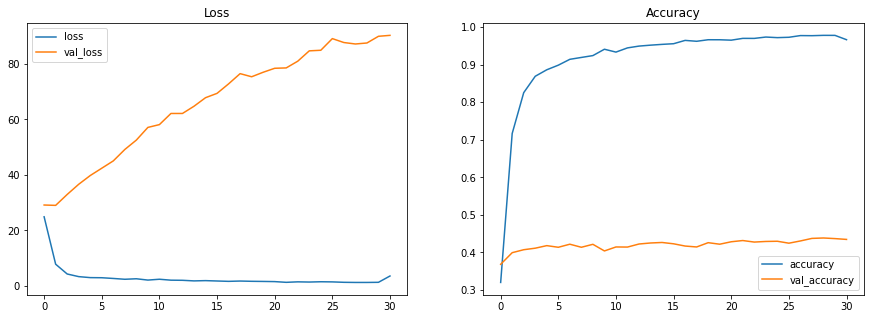

65/65 [==============================] - 1s 21ms/step - loss: 92.6662 - accuracy: 0.4368
Evaluation results: [loss, accuracy] [92.66619873046875, 0.43683186173439026]


In [ ]:
# Evaluate and Save model
learning_rate = 0.001;
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

## Add data augmentation to ResNet50V2

In [ ]:
# Create data augmentation processors

# https://www.tensorflow.org/api_docs/python/tf/image/adjust_brightness
def adjust_brightness(image, label):
    return tf.image.adjust_brightness(image, 0.01), label

# https://www.tensorflow.org/api_docs/python/tf/image/adjust_contrast
def adjust_contrast(image, label):
    return tf.image.adjust_contrast(image, 1.2), label

# Apply data processing + data augmentation steps
data_process_list=[load_image, normalize, adjust_brightness, adjust_contrast]

# Build data generators for train, validate, test
train_data, validation_data, test_data = build_data_generators(train_data_process_list=data_process_list)
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <BatchDataset shapes: ((None, 128, 128, 3), (None, 120)), types: (tf.float32, tf.float32)>
validation_data <BatchDataset shapes: ((None, 128, 128, 3), (None, 120)), types: (tf.float32, tf.float32)>
test_data <BatchDataset shapes: ((None, 128, 128, 3), (None, 120)), types: (tf.float32, tf.float32)>


### Build model

In [ ]:
############################
# Training Params
############################
batch_size = 32
epochs = 50
############################

# Early Stopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10);

# Model Checkpoint
checkpoint_filepath = './Checkpoints/checkpoint_ResNet50V2DataAug'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

# Build the model
model = build_resnet_model(model_name='ResNet50V2_DataAug')

# Loads the weights
checkpoint_path = './Checkpoints/checkpoint_ResNet50V2'
model.load_weights(checkpoint_path)

# Optimier
optimizer = optimizers.Adam()

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])





Model: "ResNet50V2_DataAug"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________

### Train model

In [ ]:
# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[earlystopping,model_checkpoint_callback],
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)



Epoch 1/50
462/463 [============================>.] - ETA: 0s - loss: 31.2736 - accuracy: 0.7894
Epoch 00001: val_accuracy improved from -inf to 0.80870, saving model to ./Checkpoints/checkpoint_ResNet50V2DataAug
463/463 [==============================] - 22s 48ms/step - loss: 31.2678 - accuracy: 0.7896 - val_loss: 27.2451 - val_accuracy: 0.8087
Epoch 2/50
463/463 [==============================] - ETA: 0s - loss: 5.5190 - accuracy: 0.9209
Epoch 00002: val_accuracy improved from 0.80870 to 0.81929, saving model to ./Checkpoints/checkpoint_ResNet50V2DataAug
463/463 [==============================] - 20s 43ms/step - loss: 5.5190 - accuracy: 0.9209 - val_loss: 26.4986 - val_accuracy: 0.8193
Epoch 3/50
463/463 [==============================] - ETA: 0s - loss: 1.6329 - accuracy: 0.9644
Epoch 00003: val_accuracy did not improve from 0.81929
463/463 [==============================] - 20s 43ms/step - loss: 1.6329 - accuracy: 0.9644 - val_loss: 26.3340 - val_accuracy: 0.8182
Epoch 4/50
462/463

### Evaluate and Save

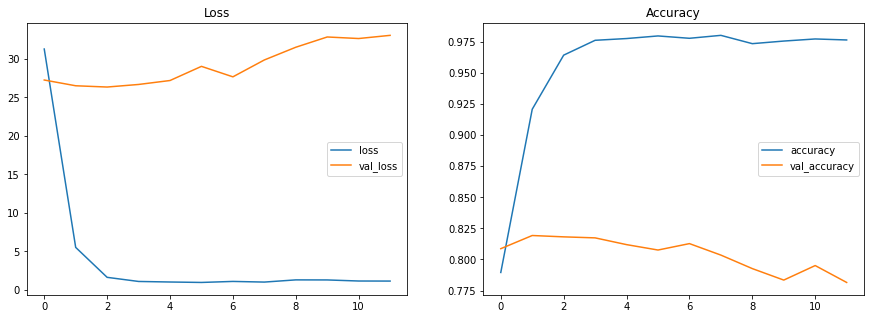

65/65 [==============================] - 1s 19ms/step - loss: 30.7018 - accuracy: 0.7901
Evaluation results: [loss, accuracy] [30.701765060424805, 0.7900874614715576]


In [ ]:
# Evaluate and Save model
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

## Display predictions

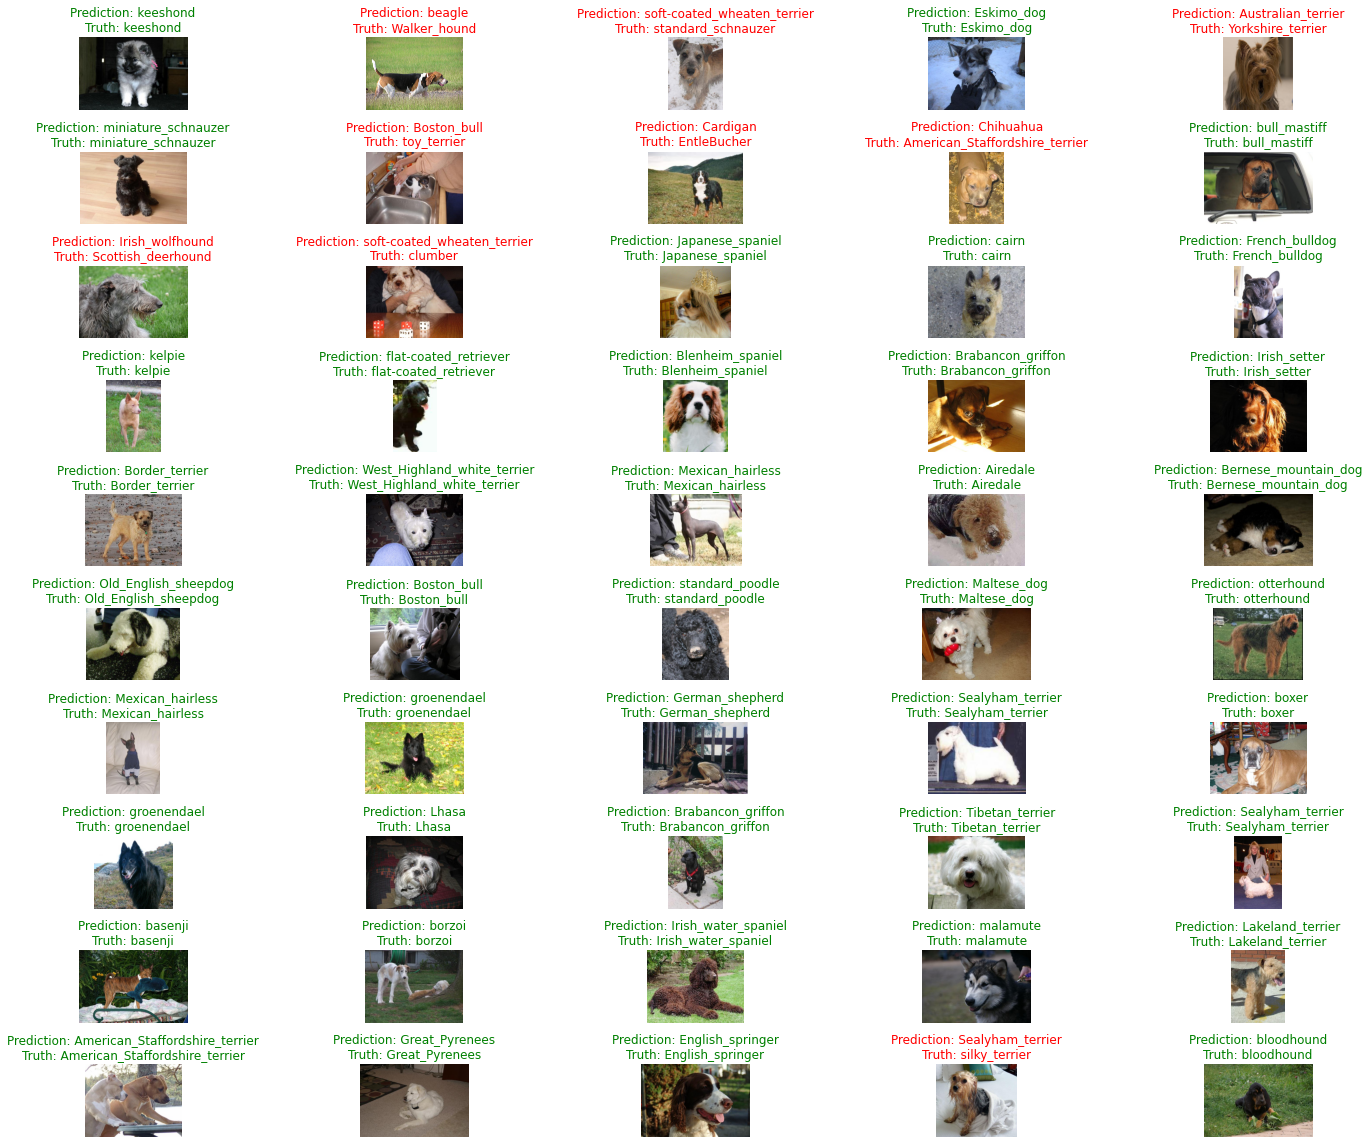

# of true predictions:  41
# of false predictions:  9


In [ ]:
# load best model with best weights
prediction_model = tf.keras.models.load_model('./SavedModels/ResNet50V2_DataAug.hdf5')
checkpoint_path = './Checkpoints/checkpoint_ResNet50V2DataAug'
prediction_model.load_weights(checkpoint_path)

# make predictions
test_predictions = prediction_model.predict(test_data)

# Load Test images
test_x_display = []
for path in test_x:
    # read image
    image = cv2.imread(path)
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Train x
    test_x_display.append(image)

# Convert to numpy array
test_x_display = np.asarray(test_x_display)

# add true and predicted breed for each dog image
# mark it green if prediction is true, otherwise red
# count the total number of true predictions for the first 100 images
true_predict = 0
false_predict = 0
fig = plt.figure(figsize=(20,16))
for i,file in enumerate(test_x_display[:50]):
    axs = fig.add_subplot(10,5,i+1)
    axs.set_aspect('equal')
    predicted_breed = index2label[test_predictions.argmax(axis=1)[i]][10:] # [10:] truncates leading unnecessary letters
    true_breed = test_y[i][10:]
    # color code true/false predictions
    if true_breed == predicted_breed:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='green')
      true_predict += 1
    else:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='red')
      false_predict += 1
    plt.imshow(test_x_display[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

print('# of true predictions: ', true_predict)
print('# of false predictions: ', false_predict)